# RTL-SDR Ultrasound Test
Copyright (C) 2018 William Meng

This file is part of rtlsdr_ultrasound

rtlsdr_ultrasound is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

rtlsdr_ultrasound is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with rtlsdr_ultrasound.  If not, see <http://www.gnu.org/licenses/>.

-------
William Meng K9TTL  
Aug 13, 2018

In this notebook, I will demonstrate how to:
* use pyrtlsdr to receive IQ samples of ultrasound data
* extract the envelope of the ultrasound signal
* approximately reconstruct the original ultrasound signal (albeit with different initial phase)
* slice the scanlines according to a trigger threshold and holdoff time
* plot a 2D image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rtlsdr import *
from scipy.signal import resample
from scipy.signal import hilbert
import time
from datetime import datetime
%matplotlib inline

## Configure settings for RTL-SDR

In [25]:
sdr = RtlSdr()

# configure device
sdr.set_direct_sampling(2) # directly sample Q channel
sdr.center_freq = 8e6
sdr.sample_rate = 2.4e6
sdr.gain = 'auto'

center_freq = sdr.center_freq
sample_rate = sdr.sample_rate
print("center freq = {} Hz".format(center_freq))
print("sample rate = {} Hz".format(sample_rate))
print("gain = {}".format(sdr.gain))

center freq = 8000000 Hz
sample rate = 2400000.0 Hz
gain = 0.0


## Acquire data and save to file

In [3]:
# read samples
samples = sdr.read_samples(256*512)
sdr.close()

# save samples to disk with timestamp
timestamp = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H:%M:%S')
np.save("rtlsdr_ultrasound_test_{}".format(timestamp), samples)

## Load data from file and plot

[-0.00392157+0.00392157j  0.00392157+0.00392157j -0.00392157-0.00392157j
 ...,  0.00392157+0.00392157j  0.00392157+0.00392157j
 -0.00392157+0.00392157j]
Found 131072 samples


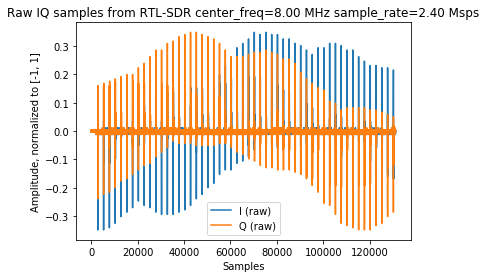

In [22]:
samples = np.load("rtlsdr_ultrasound_test_2018-08-13_13:16:29.npy")
print(samples)
print("Found {} samples".format(len(samples)))
I_raw = np.real(samples)
Q_raw = np.imag(samples)
plt.plot(I_raw, label="I (raw)")
plt.plot(Q_raw, label="Q (raw)")
plt.title("Raw IQ samples from RTL-SDR center_freq=%.2f MHz sample_rate=%.2f Msps" % (center_freq/1e6, sample_rate/1e6))
plt.xlabel("Samples")
plt.ylabel("Amplitude, normalized to [-1, 1]")
plt.legend()
plt.show()

## Process signal
### Upsample and generate time base

In [23]:
upsampling_factor = 10
resampled = resample(samples, len(samples) * upsampling_factor)
fs = sample_rate * upsampling_factor
Ts = 1e6/fs # time per sample after resampling, in microseconds
print("Resampled at:")
print("fs = %.2f Msps" % (fs/1e6))
print("Ts = {} microseconds".format(Ts))
t = np.array([ x * Ts for x in range(len(resampled))]) # time base, in microseconds

Resampled at:
fs = 24.00 Msps
Ts = 0.041666666666666664 microseconds


### Plot envelope

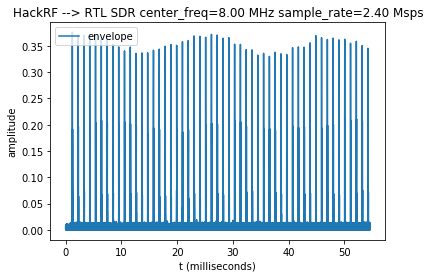

In [33]:
envelope = np.abs(resampled)
t_ms = t/1000
plt.plot(t_ms, envelope, label="envelope")
plt.xlabel('t (milliseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

*[Let's enhance](https://www.youtube.com/watch?v=LhF_56SxrGk) the image...*

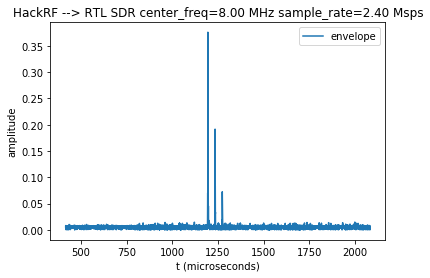

In [32]:
start = 10000
end = 50000
zoomed_envelope = envelope[start:end]
zoomed_t = t[start:end]
plt.plot(zoomed_t, zoomed_envelope, label="envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

*What's that over there? Zoom and enhance.*

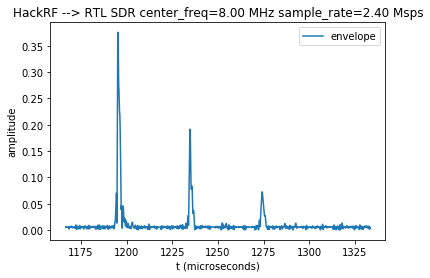

In [40]:
start = 28000
end = 32000
megazoomed_envelope = envelope[start:end]
megazoomed_t = t[start:end]
plt.plot(megazoomed_t, megazoomed_envelope, label="envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

~~Look over there, it's a corneal reflection!~~

We have an envelope signal that corresponds nicely to the original data from kelu124:  
![example data from un0rick](https://raw.githubusercontent.com/kelu124/un0rick/master/images/20180403/p_A-130us-0-VGA%400x22-spimode1-64msps.jpg)

## Approximate reconstruction of original ultrasound signal

~~Use vector a6 to rotate it 75 degrees around the vertical please...~~

There's no guarantee that my LO_cos and LO_sin have an intial phase matching the ultrasound signal's initial phase.
Also, there's no guarantee that the LO frequency is exactly equal to ultrasound signal's frequency
(which should equal the resonant frequency of the piezo transducer).
But this is still a good way to approximately visualize the relation of the envelope signal to the original ultrasound signal.

The IQ samples only describe how the RF signal is modulated, and convey no information whatsoever about the carrier signal.